In [16]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from sklearn.metrics import roc_auc_score

import sys
sys.path.append('../')
from divdis import DivDis, DivDisLoss

# Data Generation

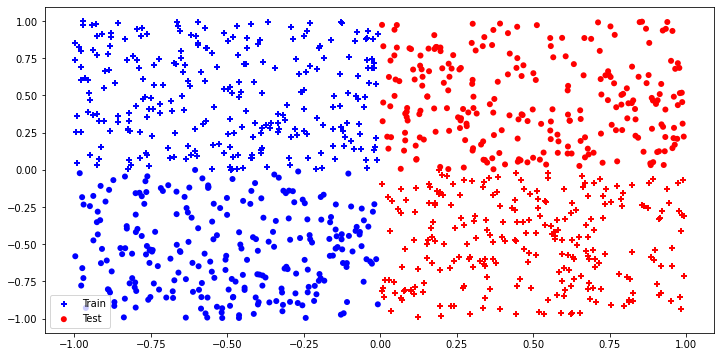

In [22]:
X = np.random.uniform(-1, 1, size=(1000, 2))
y = (X[:, 0] > 0).astype(int)
split = (np.sign(X[:, 0]) == np.sign(X[:, 1])).astype(int)

X_train = torch.from_numpy(X[split == 0]).float()
y_train = torch.from_numpy(y[split == 0]).long()
y_probas = torch.from_numpy(np.unique(y[split == 0], return_counts=True)[1] / y[split == 0].shape[0]).float()
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)

X_test = torch.from_numpy(X[split == 1]).float()
y_test = torch.from_numpy(y[split == 1]).long()
test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)


def plot_train_and_test():
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='P', cmap='bwr', lw=0, label='Train')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', lw=0, label='Test')
    plt.legend()
    

plt.figure(figsize=(12, 6))
plot_train_and_test()

In [18]:
c = 4
bb = nn.Sequential(nn.Linear(X_train.shape[1], c), nn.ReLU(),
                   nn.Linear(c, c), nn.ReLU(),
)

clf = DivDis(bb, c, 2, torch.unique(y_train).shape[0])
clf.train()
loss_fn = DivDisLoss(y_probas, lambda_mi=1., lambda_reg=None)

optimizer = optim.Adam(bb.parameters(), lr=0.05)
# optimizer = optim.SGD(bb.parameters(), lr=.5, momentum=0.9, nesterov=True)

for i in range(500):

    for batch in zip(train_loader, test_loader):
        (xb_train, yb_train), (xb_test, yb_test) = batch
    
        optimizer.zero_grad()
        y_pred = clf(xb_train)
        y_test_pred = clf(xb_test)

        verbose = ((i + 1) % 100 == 0)

        loss = loss_fn(y_pred , yb_train, y_test_pred, verbose=verbose)
        loss.backward()
        optimizer.step()
        if verbose:
            print(loss.item())


Loss Xent 0.01211157999932766
Loss MI 0.00024506496265530586
Loss reg 0.0
0.012356644496321678
Loss Xent 0.00695513840764761
Loss MI 0.002140250988304615
Loss reg 0.0
0.009095389395952225
Loss Xent 0.003406620817258954
Loss MI 5.455361679196358e-05
Loss reg 0.0
0.0034611744340509176
Loss Xent 0.01060829684138298
Loss MI 0.0010496904142200947
Loss reg 0.0
0.011657986789941788
Loss Xent 0.000569228024687618
Loss MI 3.475847188383341e-05
Loss reg 0.0
0.0006039864965714514
Loss Xent 0.0008949218317866325
Loss MI 0.0007564164698123932
Loss reg 0.0
0.0016513383015990257
Loss Xent 0.00038242823211476207
Loss MI 0.004775146953761578
Loss reg 0.0
0.005157575011253357
Loss Xent 0.0004384624771773815
Loss MI 0.0004512818995863199
Loss reg 0.0
0.0008897443767637014
Loss Xent 0.005243855528533459
Loss MI 0.00018017017282545567
Loss reg 0.0
0.005424025468528271
Loss Xent 0.009009146131575108
Loss MI 4.532223101705313e-06
Loss reg 0.0
0.009013677947223186
Loss Xent 0.0037263273261487484
Loss MI 0.000

Head 0 Score on test: 0.18269454123112663


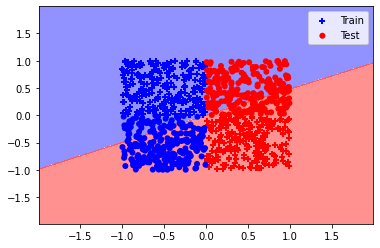

Head 1 Score on test: 0.8274099883855982


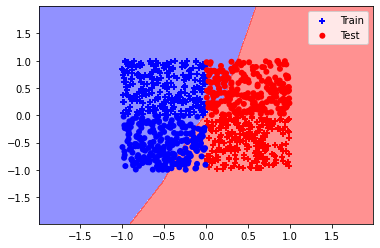

In [25]:
def plot_decision_boundary(model, steps=1000, color_map='bwr'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    ymin, ymax = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).detach().numpy()

    # Plot decision boundary in region of interest
    labels_predicted = (labels_predicted > 0.5).argmax(axis=1)
    z = np.array(labels_predicted).reshape(xx.shape)
    
    plt.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    
    plot_train_and_test()
    plt.show()


clf.eval()
for i in range(len(clf.heads)):
    clf.set_active_head(i)
    print('Head {} Score on test:'.format(i),
          roc_auc_score(
              y_test.detach().numpy(),
              clf.forward(X_test).detach().numpy()[:, 1]))
    plot_decision_boundary(clf)